In [1]:
import pandas as pd
import numpy as np

column_names_full = [
    "track_id", "race_date", "race_number", "program_number",
    "trakus_index", "latitude", "longitude", "distance_id",
    "course_type", "track_condition", "run_up_distance", 
    "race_type", "post_time", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

column_names_desired = [
    "race_date", "race_number", "program_number", "trakus_index", "latitude", "longitude", "distance_id", "course_type", "track_condition",
    "race_type", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

# Load the dataset
df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]

# Inspect the data
df.info()
df.head()

C:\Users\ahmet\AppData\Local\Temp\ipykernel_13144\3901139008.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   race_date           object 
 1   race_number         int64  
 2   program_number      object 
 3   trakus_index        int64  
 4   latitude            float64
 5   longitude           float64
 6   distance_id         int64  
 7   course_type         object 
 8   track_condition     object 
 9   race_type           object 
 10  weight_carried      int64  
 11  jockey              object 
 12  odds                int64  
 13  position_at_finish  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 558.5+ MB


,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,race_type,weight_carried,jockey,odds,position_at_finish
0,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
1,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
2,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
3,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
4,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8


In [2]:
# Preprocessing
# ---
# Dropping nulls
df = df.dropna(axis=0)

# Getting only a fraction of the total data for easier computation.
df = df.sample(frac=0.5, random_state=42)

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['distance_id', 'weight_carried', 'odds']] = scaler.fit_transform(df[['distance_id', 'weight_carried', 'odds']])

# Scaled columns
df.head()[['distance_id', 'weight_carried', 'odds']]

,distance_id,weight_carried,odds
3350553,0.290323,0.20,0.021990
2424821,0.096774,0.06,0.030366
3572973,0.129032,0.20,0.021990
3809994,0.258065,0.20,0.092670
992396,0.290323,0.16,0.094764


In [3]:
# Feature Engineering Preparation

# Defining the Haversine formula for calculating the distance using the latitude and longitude data available.
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c * 1000  # Convert to meters

In [4]:
# Feature Engineering 
    # Engineering the following Features related to positions:
        # Positional change
        # Pace consistency
        # Position difference relative to other competitors
        # Positional stability
        # Expected Finnish positionm
        # Late-race performance

df = df.sort_values(by='race_date')

# Calculate distance for each horse at each trakus_index
# Trakus index is the common collection of point of the lat / long of the horse in the race passed as an integer, collected every 0.25 seconds
df['lat_shift'] = df.groupby('program_number')['latitude'].shift(1)
df['lon_shift'] = df.groupby('program_number')['longitude'].shift(1)

df['distance_traveled'] = haversine(
    df['latitude'], df['longitude'], df['lat_shift'], df['lon_shift']
)

df['distance_traveled'] = df['distance_traveled'].fillna(0)

# Cumulative distance, to be used for comparison later
df['cumulative_distance'] = df.groupby('program_number')['distance_traveled'].transform('cumsum')

# Calculate time difference in seconds in between each trakus record
df['time_diff'] = df.groupby('program_number')['trakus_index'].diff().fillna(0) * 0.25

# Calculate speed and acceleration using the previously calculated distance and time differences
df['speed'] = df['distance_traveled'] / df['time_diff'].replace(0, np.nan).fillna(0)
df['acceleration'] = df.groupby('program_number')['speed'].diff().fillna(0) / df['time_diff']

df['speed'] = df['speed'].replace([np.inf, -np.inf], 0).fillna(0)
df['acceleration'] = df['acceleration'].replace([np.inf, -np.inf], 0).fillna(0)

# Rank horses based on cumulative distance at each trakus_index
df['relative_position'] = df.groupby('trakus_index')['cumulative_distance'].rank(ascending=False, method='min')

# Define the last 10% of trakus_index as the final stage
max_trakus = df['trakus_index'].max()
final_stage_start = int(max_trakus * 0.9)

# Calculate features specific to the final stage
final_stage_mask = df['trakus_index'] >= final_stage_start
df['final_stage_position_change'] = 0 
df.loc[final_stage_mask, 'final_stage_position_change'] = df.loc[
    final_stage_mask
].groupby('program_number')['relative_position'].diff().fillna(0)

df['final_stage_position_change'] = df['final_stage_position_change'].fillna(0)

# Mean rank during the race as a proxy for expected position
df['expected_position'] = df.groupby('program_number')['relative_position'].transform('mean')

df['expected_position'] = df['expected_position'].replace([np.inf, -np.inf], 0).fillna(0)

# Scaling the new features
df[['expected_position', 'final_stage_position_change', 'relative_position']] = scaler.fit_transform(df[['expected_position', 'final_stage_position_change', 'relative_position']])

# Added and scaled features
df.head()[['expected_position', 'final_stage_position_change', 'relative_position']]

,expected_position,final_stage_position_change,relative_position
2436454,0.000000,0.521739,0.971211
3672449,0.247483,0.521739,0.981859
2116943,0.242367,0.521739,0.976469
1133432,0.000000,0.521739,0.957802
990374,0.241546,0.521739,0.044301


In [5]:
# Feature Engineering 
    # Engineering the following Features:
        # Jockey influence
        # Horse's relative performance on specific track types
        # Horse's relative performance on specific course types
        # Horse's relative performance on specific race types

# Mean finishing position of each jockey
df['jockey_score'] = (
    df.groupby('jockey')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

global_mean_jockey = df['jockey_score'].mean()
df['jockey_score'] = df['jockey_score'].fillna(global_mean_jockey)

# Calculate horse_track_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's track-specific mean finish position 
# for capturing the relationship in between.
df['horse_track_relative_score'] = (
    df.groupby(['program_number', 'track_condition'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse track score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's course type-specific mean finish position 
# for capturing the relationship in between.
df['horse_course_relative_score'] = (
    df.groupby(['program_number', 'course_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse course score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's race type-specific mean finish position 
# for capturing the relationship in between.
df['horse_race_relative_score'] = (
    df.groupby(['program_number', 'race_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse race score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Scaling the new features
df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']] = scaler.fit_transform(df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']])

# Added and scaled features
df.head()[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']]

,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score
2436454,0.447769,0.115411,0.099593,0.103869
3672449,0.327301,NaN,NaN,NaN
2116943,0.276319,0.116583,0.110443,0.138809
1133432,0.083333,0.100594,0.099593,0.048009
990374,0.083333,0.116511,0.114392,0.110065


In [6]:
# Correlation matrix
correlations = df[['expected_position', 'final_stage_position_change', 'relative_position', 'jockey_score', 'horse_track_relative_score', 
                   'horse_course_relative_score', 'horse_race_relative_score']].corr()
print(correlations)

# Correlations are weak, indicating that all added features are meaningful.

                             expected_position  final_stage_position_change  \
expected_position                     1.000000                     0.000086   
final_stage_position_change           0.000086                     1.000000   
relative_position                     0.473679                     0.000024   
jockey_score                          0.033297                    -0.000265   
horse_track_relative_score           -0.016698                    -0.000098   
horse_course_relative_score           0.016455                    -0.000049   
horse_race_relative_score             0.004649                    -0.000049   

                             relative_position  jockey_score  \
expected_position                     0.473679      0.033297   
final_stage_position_change           0.000024     -0.000265   
relative_position                     1.000000     -0.090614   
jockey_score                         -0.090614      1.000000   
horse_track_relative_score            0.001022 

In [7]:
# Preparing for data split
# Features list
features = [
    'expected_position', 'final_stage_position_change', 'relative_position', 'jockey_score', 'horse_track_relative_score', 
    'horse_course_relative_score', 'horse_race_relative_score', 'distance_id', 'weight_carried', 'odds',
]
target = 'position_at_finish'

from sklearn.model_selection import train_test_split

# Data split
X = pd.get_dummies(df[features])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from sklearn.impute import SimpleImputer

# Fill missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Describe the train data
X_train.describe()

,expected_position,final_stage_position_change,relative_position,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score,distance_id,weight_carried,odds
count,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06,2.091372e+06
mean,1.906814e-01,5.217398e-01,4.369715e-01,2.711242e-01,1.031882e-01,1.021635e-01,1.023971e-01,1.977076e-01,2.142288e-01,7.763276e-02
std,2.006316e-01,2.339643e-03,2.825234e-01,6.722237e-02,1.635256e-02,1.599702e-02,1.808202e-02,1.159160e-01,8.704183e-02,1.022100e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.539407e-05,0.000000e+00,7.140656e-04,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.975735e-03,5.217391e-01,1.900881e-01,2.265365e-01,9.628944e-02,9.492872e-02,9.464634e-02,9.677419e-02,1.600000e-01,1.753927e-02
50%,2.353555e-01,5.217391e-01,4.112002e-01,2.604488e-01,1.005330e-01,9.959296e-02,1.025515e-01,2.258065e-01,2.000000e-01,3.821990e-02
75%,2.651541e-01,5.217391e-01,6.730643e-01,3.025676e-01,1.109100e-01,1.069952e-01,1.105035e-01,2.580645e-01,2.400000e-01,9.109948e-02
max,1.000000e+00,1.000000e+00,9.998685e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
# Export processed data with the target to compare

# Export processed data without the target for predictions
X.to_csv("nyra_2019_complete_processed_features.csv", index=False)
print("Processed features only data saved to 'nyra_2019_complete_processed_features.csv'")

y.to_csv("nyra_2019_complete_target.csv", index=False)
print("Target file saved to 'nyra_2019_complete_target.csv'")

Processed features only data saved to 'nyra_2019_complete_processed_features.csv'
Target file saved to 'nyra_2019_complete_target.csv'


In [19]:
# Training the model with Random Forest
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import joblib

cat_model_file = "horsemodel_catboost.pkl"

# Initialize XGBoost
cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=10,  
    bagging_temperature=1.0,  
    random_state=42,
    silent=True
)
cat_model.fit(X_train, y_train)

# Train the model
cat_model.fit(X_train, y_train)

# Evaluate the model
y_pred = cat_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Save the model
joblib.dump(cat_model, cat_model_file)

Mean Squared Error (MSE): 3.8746288881151427
R² Score: 0.4117308680320164
Mean Absolute Error (MAE): 1.5712227714911982


['horsemodel_catboost.pkl']

In [21]:
# Model Evaluation: Comparation to Baseline
baseline_pred = y_test.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
print("Baseline MSE:", baseline_mse)

Baseline MSE: 6.58649022625586


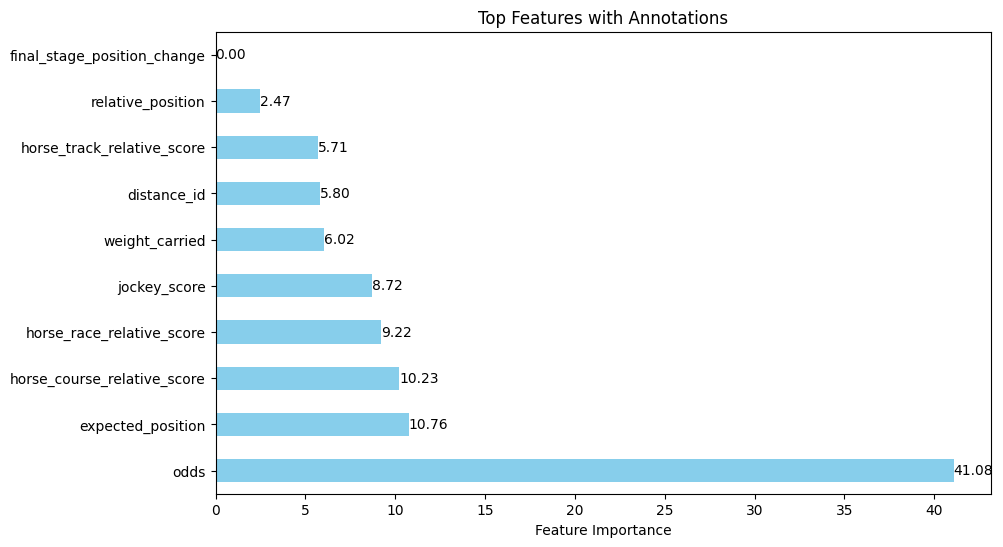

In [23]:
# Model Evaluation - Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

# Sort features by importance
feature_importances = pd.Series(cat_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')

# Annotate each bar with its value
for index, value in enumerate(top_features.sort_values()):
    plt.text(value, index, f"{value:.2f}", va='center')

plt.xlabel("Feature Importance")
plt.title("Top Features with Annotations")
plt.gca().invert_yaxis()
plt.show()

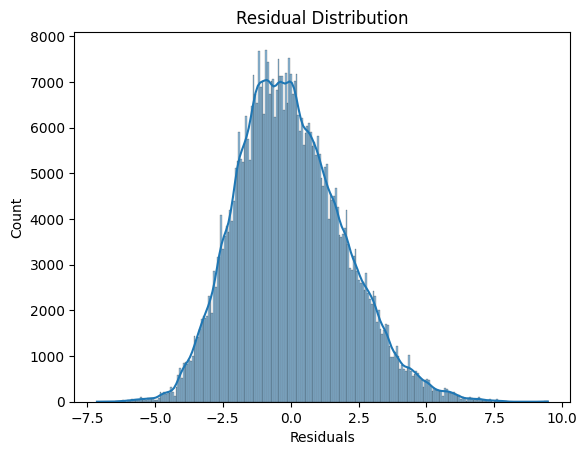

In [25]:
# Model Evaluation: Residual analysis
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

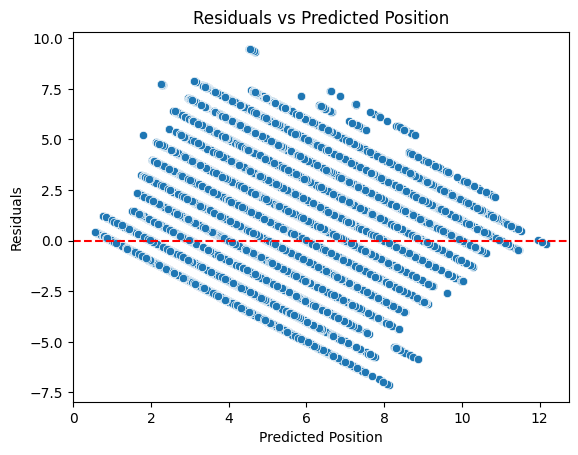

In [27]:
# Model Evaluation: Residuals vs. Predictions
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Position")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Position")
plt.show()

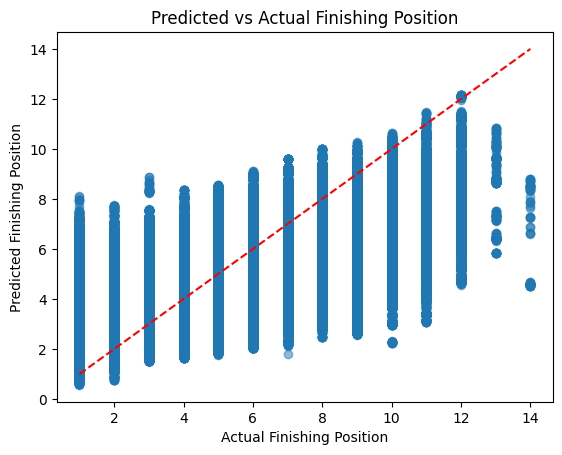

In [29]:
# Model Evaluation: Predicted vs. Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Finishing Position")
plt.ylabel("Predicted Finishing Position")
plt.title("Predicted vs Actual Finishing Position")
plt.show()